In [1]:
import time
import toml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from typing import Dict, Optional, List
from binance.client import Client
from datetime import datetime, timezone

plt.rcParams["figure.figsize"] = (20,10)
plt.rcParams["figure.dpi"] = 200
plt.rcParams.update({'font.size': 18})

In [2]:
cfg = toml.load("configuration.toml")
pkey = cfg["auth"]["pkey"]
skey = cfg["auth"]["skey"]

client = Client(pkey, skey)

## Order Validation

All orders must obey certain rules called Filters (see https://github.com/binance/binance-spot-api-docs/blob/master/rest-api.md#filters). The function `client.get_exchange_info` returns a dictionary that has a list of dictionaries containing information each symbol in the exchange. After searching through the list for the desired dict of information (say for DOGEUSDT), you can retrieve the list of filters which must be obeyed.

Quick recap of the filters. This stuff can be skimmed, then reviewed as needed.

### Price Filter - min / max price
```
{
  "filterType": "PRICE_FILTER",
  "minPrice": "0.00000100",
  "maxPrice": "100000.00000000",
  "tickSize": "0.00000100"
}
```

- `minPrice <= price <= maxPrice`
- `(price - minPrice) % tickSize == 0`


### Percent Price - valid range for price based on prev. trades
```
{
  "filterType": "PERCENT_PRICE",
  "multiplierUp": "1.3000",
  "multiplierDown": "0.7000",
  "avgPriceMins": 5
}
```
- `multiplierDown * weightedAveragePrice <= price <= multiplierUp * weightedAveragePrice`

`weightedAveragePrice` from exchange info for that symbol

### Lot Size - min/max quantity
```
{
  "filterType": "LOT_SIZE",
  "minQty": "0.00100000",
  "maxQty": "100000.00000000",
  "stepSize": "0.00100000"
}
```
- `minQty <= quantity <= maxQty`
- `(quantity-minQty) % stepSize == 0`
If it is an Iceberg order, the quantity for each Iceberg order must satisfy this.

### Min Notional - min/max value
```
{
  "filterType": "MIN_NOTIONAL",
  "minNotional": "0.00100000",
  "applyToMarket": true,
  "avgPriceMins": 5
}
```
- `price * quantity > minNotional`

if `applyToMarket`, Market Orders also must obey this filter. Since market orders have no price, the average price is used over the last `avgPriceMinutes` mins, w/ `avgPriceMinutes == 0` implying that the last price will be used.

### Iceberg Parts - rule for breaking up big orders
```
{
  "filterType": "ICEBERG_PARTS",
  "limit": 10
}
```
Defines the maximum number of parts that an Iceberg Order can have. Number of `ICEBERG_PARTS` is `CEIL(qty / icebergQty)`.

### Market Lot Size - same as Lot size, but for Market Orders

### Max Num Orders - max orders that can be open on a symbol
```
{
  "filterType": "MAX_NUM_ORDERS",
  "maxNumOrders": 25
}
```
There is also `Max num algo orders`, `Max num iceberg orders`, `Exchange max num orders`, `Exchange max num algo orders`, all of which follow the same format.

### Max Position Filter - Defines the allowed max position an account can have on the base asset of a symbol
```
{
  "filterType":"MAX_POSITION",
  "maxPosition":"10.00000000"
}
```
Defined as sum of the account's
1. Free balance of base asset
2. Locked balance of base asset
3. Sum of the quantity of all open BUY orders

In [5]:
"""
This function is now in filter_conform.py

>>> from filter_conform import get_exchange_info_for_symbol
"""

def get_exchange_info_for_symbol(client: Client, symbol: str) -> Optional[Dict]:
    exchange_info = client.get_exchange_info()
    for symbol_data in exchange_info["symbols"]:
        if symbol_data["symbol"] == symbol:
            return symbol_data
    return None

get_exchange_info_for_symbol(client, "DOGEUSDT")

{'symbol': 'DOGEUSDT',
 'status': 'TRADING',
 'baseAsset': 'DOGE',
 'baseAssetPrecision': 8,
 'quoteAsset': 'USDT',
 'quotePrecision': 8,
 'quoteAssetPrecision': 8,
 'baseCommissionPrecision': 8,
 'quoteCommissionPrecision': 8,
 'orderTypes': ['LIMIT',
  'LIMIT_MAKER',
  'MARKET',
  'STOP_LOSS_LIMIT',
  'TAKE_PROFIT_LIMIT'],
 'icebergAllowed': True,
 'ocoAllowed': True,
 'quoteOrderQtyMarketAllowed': True,
 'isSpotTradingAllowed': True,
 'isMarginTradingAllowed': True,
 'filters': [{'filterType': 'PRICE_FILTER',
   'minPrice': '0.00001000',
   'maxPrice': '1000.00000000',
   'tickSize': '0.00001000'},
  {'filterType': 'PERCENT_PRICE',
   'multiplierUp': '5',
   'multiplierDown': '0.2',
   'avgPriceMins': 5},
  {'filterType': 'LOT_SIZE',
   'minQty': '0.10000000',
   'maxQty': '9000000.00000000',
   'stepSize': '0.10000000'},
  {'filterType': 'MIN_NOTIONAL',
   'minNotional': '10.00000000',
   'applyToMarket': True,
   'avgPriceMins': 5},
  {'filterType': 'ICEBERG_PARTS', 'limit': 10},


## Order Types

From https://www.binance.com/en/support/articles/360033779452

### Limit

A limit order is an order that you place on the order book with a specific limit price. The limit price is determined by you. So when you place a limit order, the trade will only be executed if the market price reaches your limit price (or better). Therefore, you may use limit orders to buy at a lower price or to sell at a higher price than the current market price.

Unlike market orders, where trades are executed instantly at the current market price, limit orders are placed on the order book and are not executed immediately, meaning that you save on fees as a market maker.

#### When should you use it?

You should use limit orders when you are not in a rush to buy or sell. Unlike market orders, the limit orders are not executed instantly, so you need to wait until your ask/bid price is reached. Limit orders allow you to get better selling and buying prices and they are usually placed on major support and resistance levels. You may also split your buy/sell order into many smaller limit orders, so you get a cost average effect.

### Market

A market order is an order to quickly buy or sell at the best available current price. It needs liquidity to be filled, meaning that it is executed based on the limit orders that were previously placed on the order book.

Unlike limit orders, where orders are placed on the order book, market orders are executed instantly at the current market price, meaning that you pay the fees as a market taker.

#### When should you use it?

Market orders are handy in situations where getting your order filled is more important than getting a certain price. This means that you should only use market orders if you are willing to pay higher prices and fees caused by the slippage. In other words, market orders should only be used if you are in a rush.

Sometimes you might be in a situation where you had a stop-limit order that was passed over, and you need to buy/sell as soon as possible. So if you need to get into a trade right away or get yourself out of trouble, that's when market orders come in handy.
However, if you're just coming into crypto for the first time and you are using Bitcoin to buy some altcoins, avoid using market orders because you will be paying way more than you should. In this case, you should use limit orders.

### Stop-Limit / Stop-Market

https://www.binance.com/en/support/faq/360036351051

Conditional trade over a set timeframe with "stop price" / "limit price" features. A stop-limit / stop-market order will be executed after a given stop price has been reached. At this point, the stop-limit / stop-market order turns into a normal limit / market order.



## Steps to execute buy/sell order

1. `get_exchange_info` and filter for the desired symbols to find the "Filters" for each symbol
2. Build order conforming to "Filters" for the desired symbol (depending on type of order? Since Market Orders execute instantly on the best possible open bid, we would probably want to go with those)
3. Execute order
4. Profit????

To get the stream of market info, see websocket stuff near bottom of notebook

In [4]:
doge_usd_tick_data = client.get_ticker(symbol="DOGEUSDT")

v = doge_usd_tick_data
print(doge_usd_tick_data)

bid_price = doge_usd_tick_data["lastPrice"]
quantity = 100

min_quantity = f"{1 + round(10.00000000 / float(bid_price)):.8f}"

client.create_test_order(
    symbol="DOGEUSDT",
    side=client.SIDE_BUY,
    type=client.ORDER_TYPE_MARKET,
    quantity=min_quantity,
)

{'symbol': 'DOGEUSDT', 'priceChange': '-0.01482000', 'priceChangePercent': '-3.304', 'weightedAvgPrice': '0.41146581', 'prevClosePrice': '0.44859000', 'lastPrice': '0.43377000', 'lastQty': '1620.00000000', 'bidPrice': '0.43338000', 'bidQty': '3189.10000000', 'askPrice': '0.43377000', 'askQty': '25879.00000000', 'openPrice': '0.44859000', 'highPrice': '0.46359000', 'lowPrice': '0.35160000', 'volume': '9269717274.50000000', 'quoteVolume': '3814171697.61934500', 'openTime': 1620859166398, 'closeTime': 1620945566398, 'firstId': 206110189, 'lastId': 209799336, 'count': 3689148}


{}

# Data Mining

We want that sweet sweet data. Best endpoint for that is `client.get_historical_trades(symbol="SYMBOL")`, which gives trades in chunks of 500 from some ID (default is most recent).

To get a big ol dataset of historical data,
1. run `historical_trades = client.get_historical_trades(symbol="SYMBOL")` and save the data
2. get minimum id by `min_id = historical_trades[0]["id"]`
3. `goto 1`, but this time include `fromId=str(min_id - 500)`

Since the trade IDs are sequential, you can also totally start from id 0 and work your way up to the most current trades.

In [7]:
historical_trades = client.get_historical_trades(symbol="DOGEBTC")

trade_ids = [trd["id"] for trd in historical_trades]

trade_times = [trd["time"] / 100 for trd in historical_trades]
trade_dts = [datetime.fromtimestamp(timestamp, timezone.utc) for timestamp in trade_times]

Text(0, 0.5, 'trade number (of the previous 500 trades)')

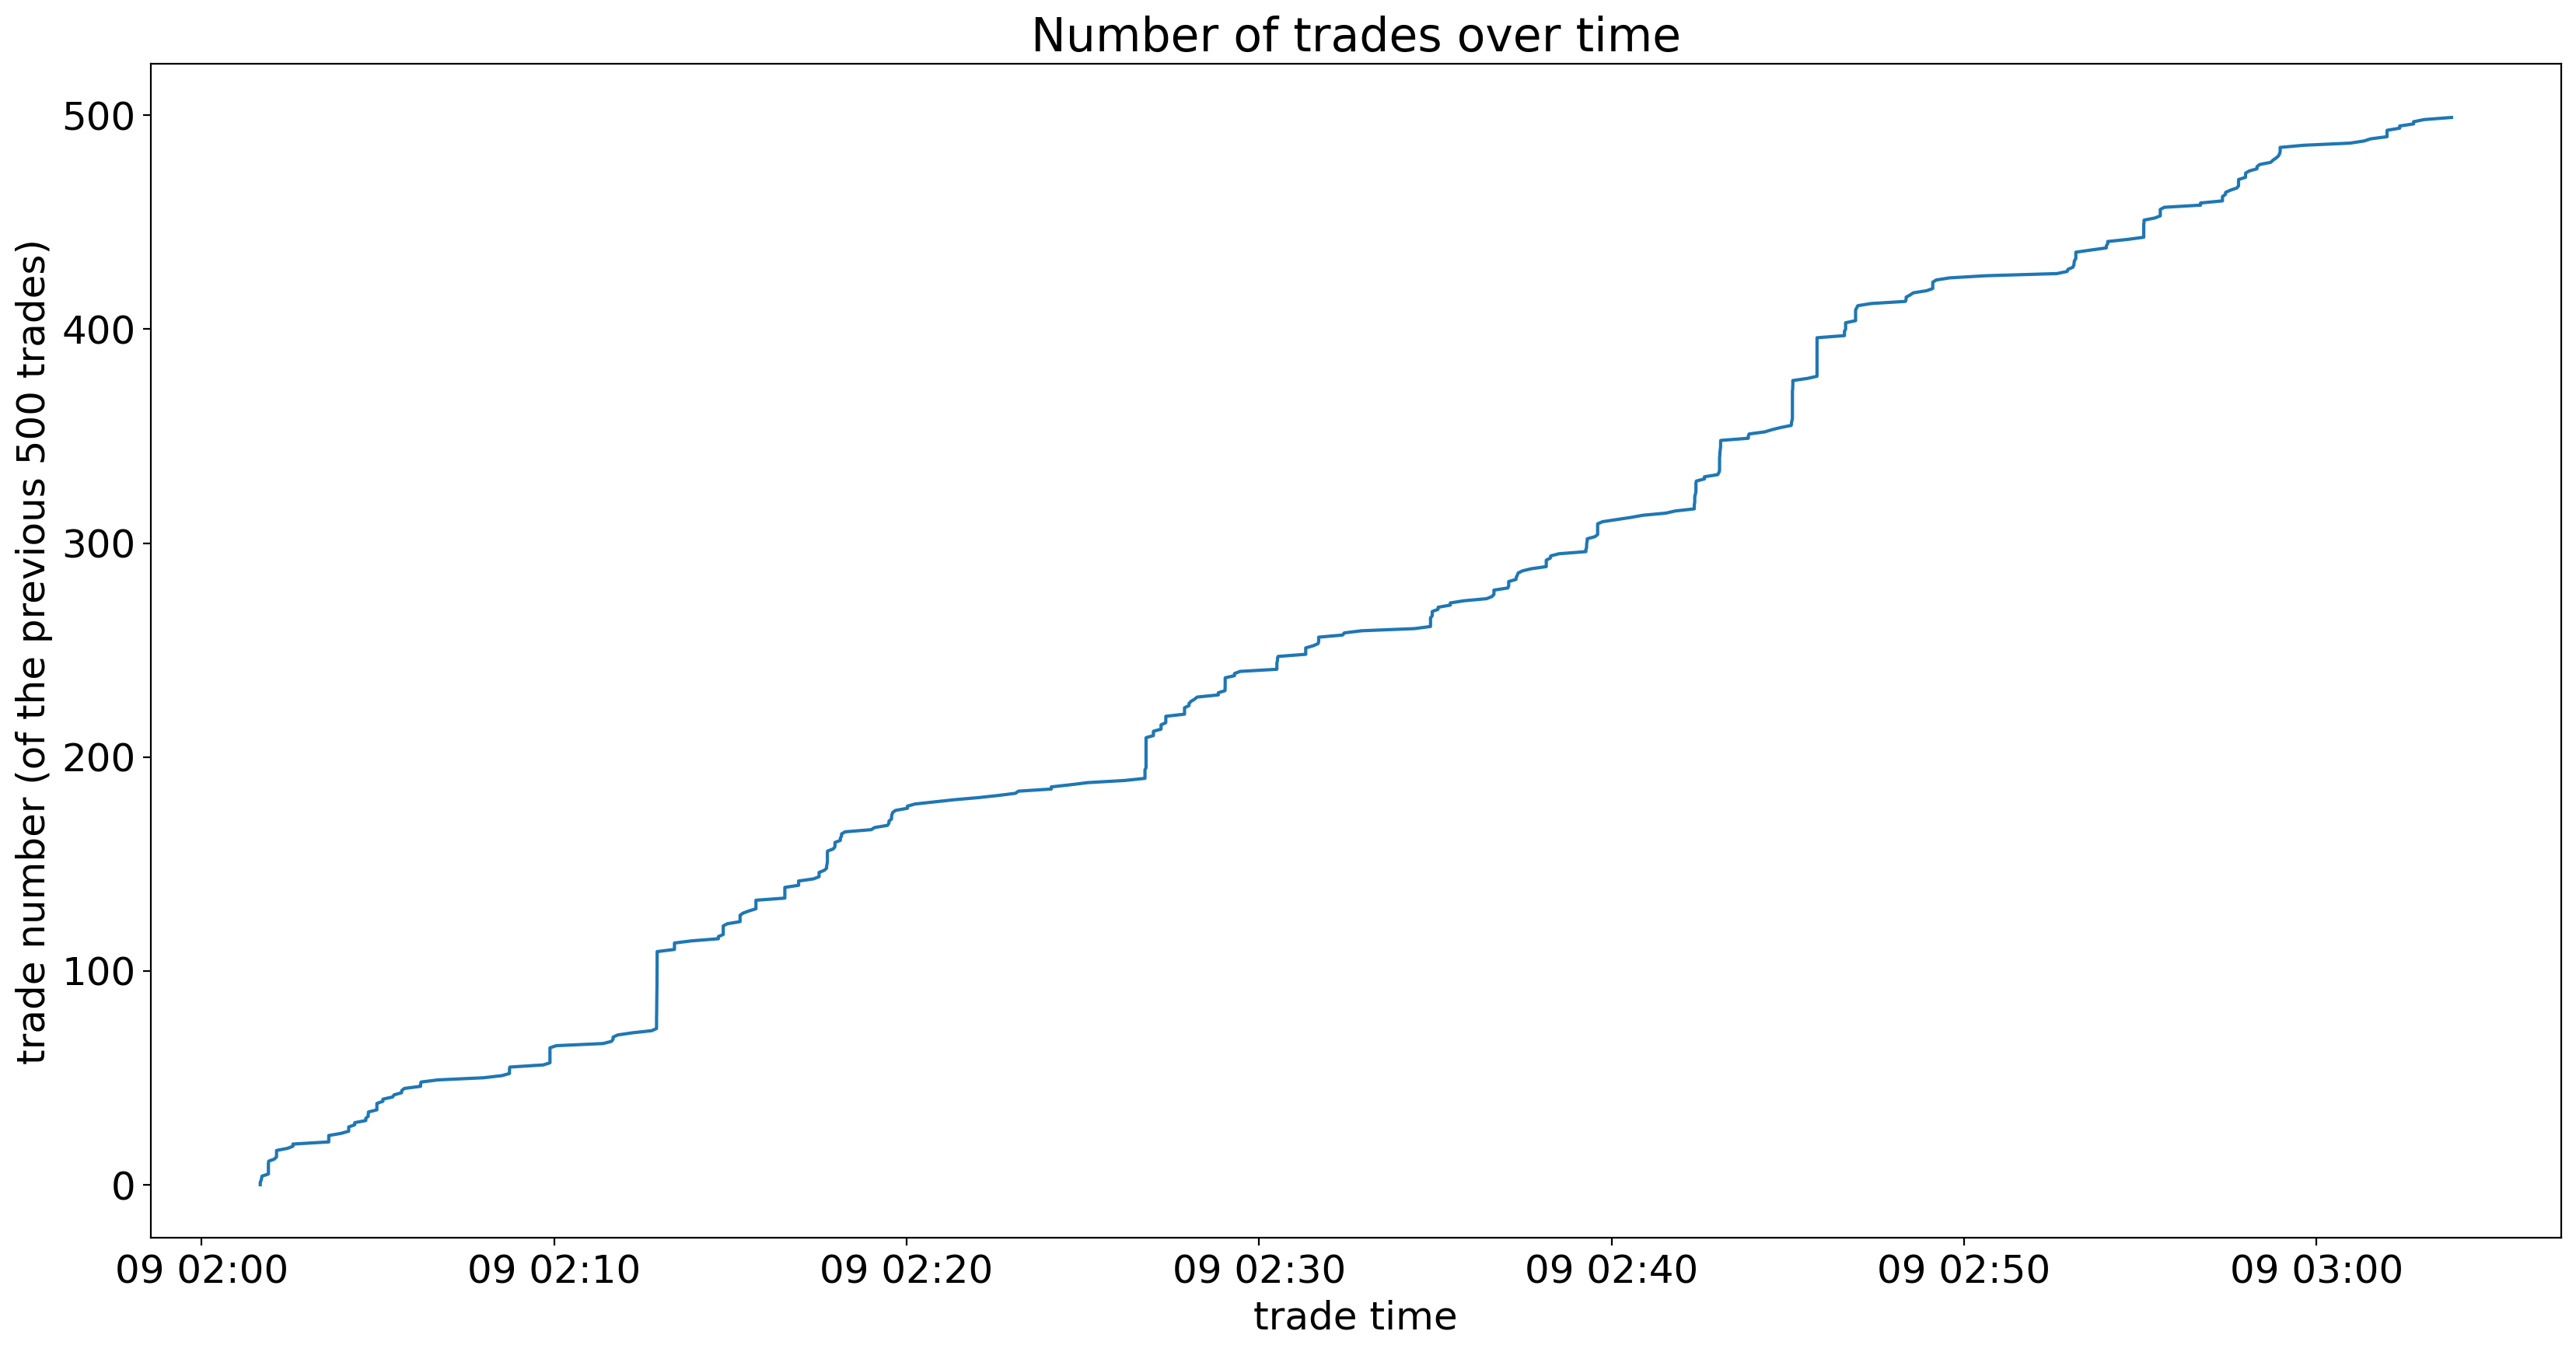

In [8]:
plt.plot(trade_dts, [i for i in range(len(trade_dts))])
plt.title("Number of trades over time")
plt.xlabel("trade time")
plt.ylabel("trade number (of the previous 500 trades)")

In [7]:
print(f"Max dt: {max(np.diff(trade_dts))}\nMin dt: {min(np.diff(trade_dts))}\nMean dt: {(max(trade_dts) - min(trade_dts)) / len(np.diff(trade_dts))}")  # say yes to calcualting the same thing 4 times pointlessly

Max dt: 0:00:02.509998
Min dt: 0:00:00
Mean dt: 0:00:00.251182


Text(0, 0.5, 'number of trades')

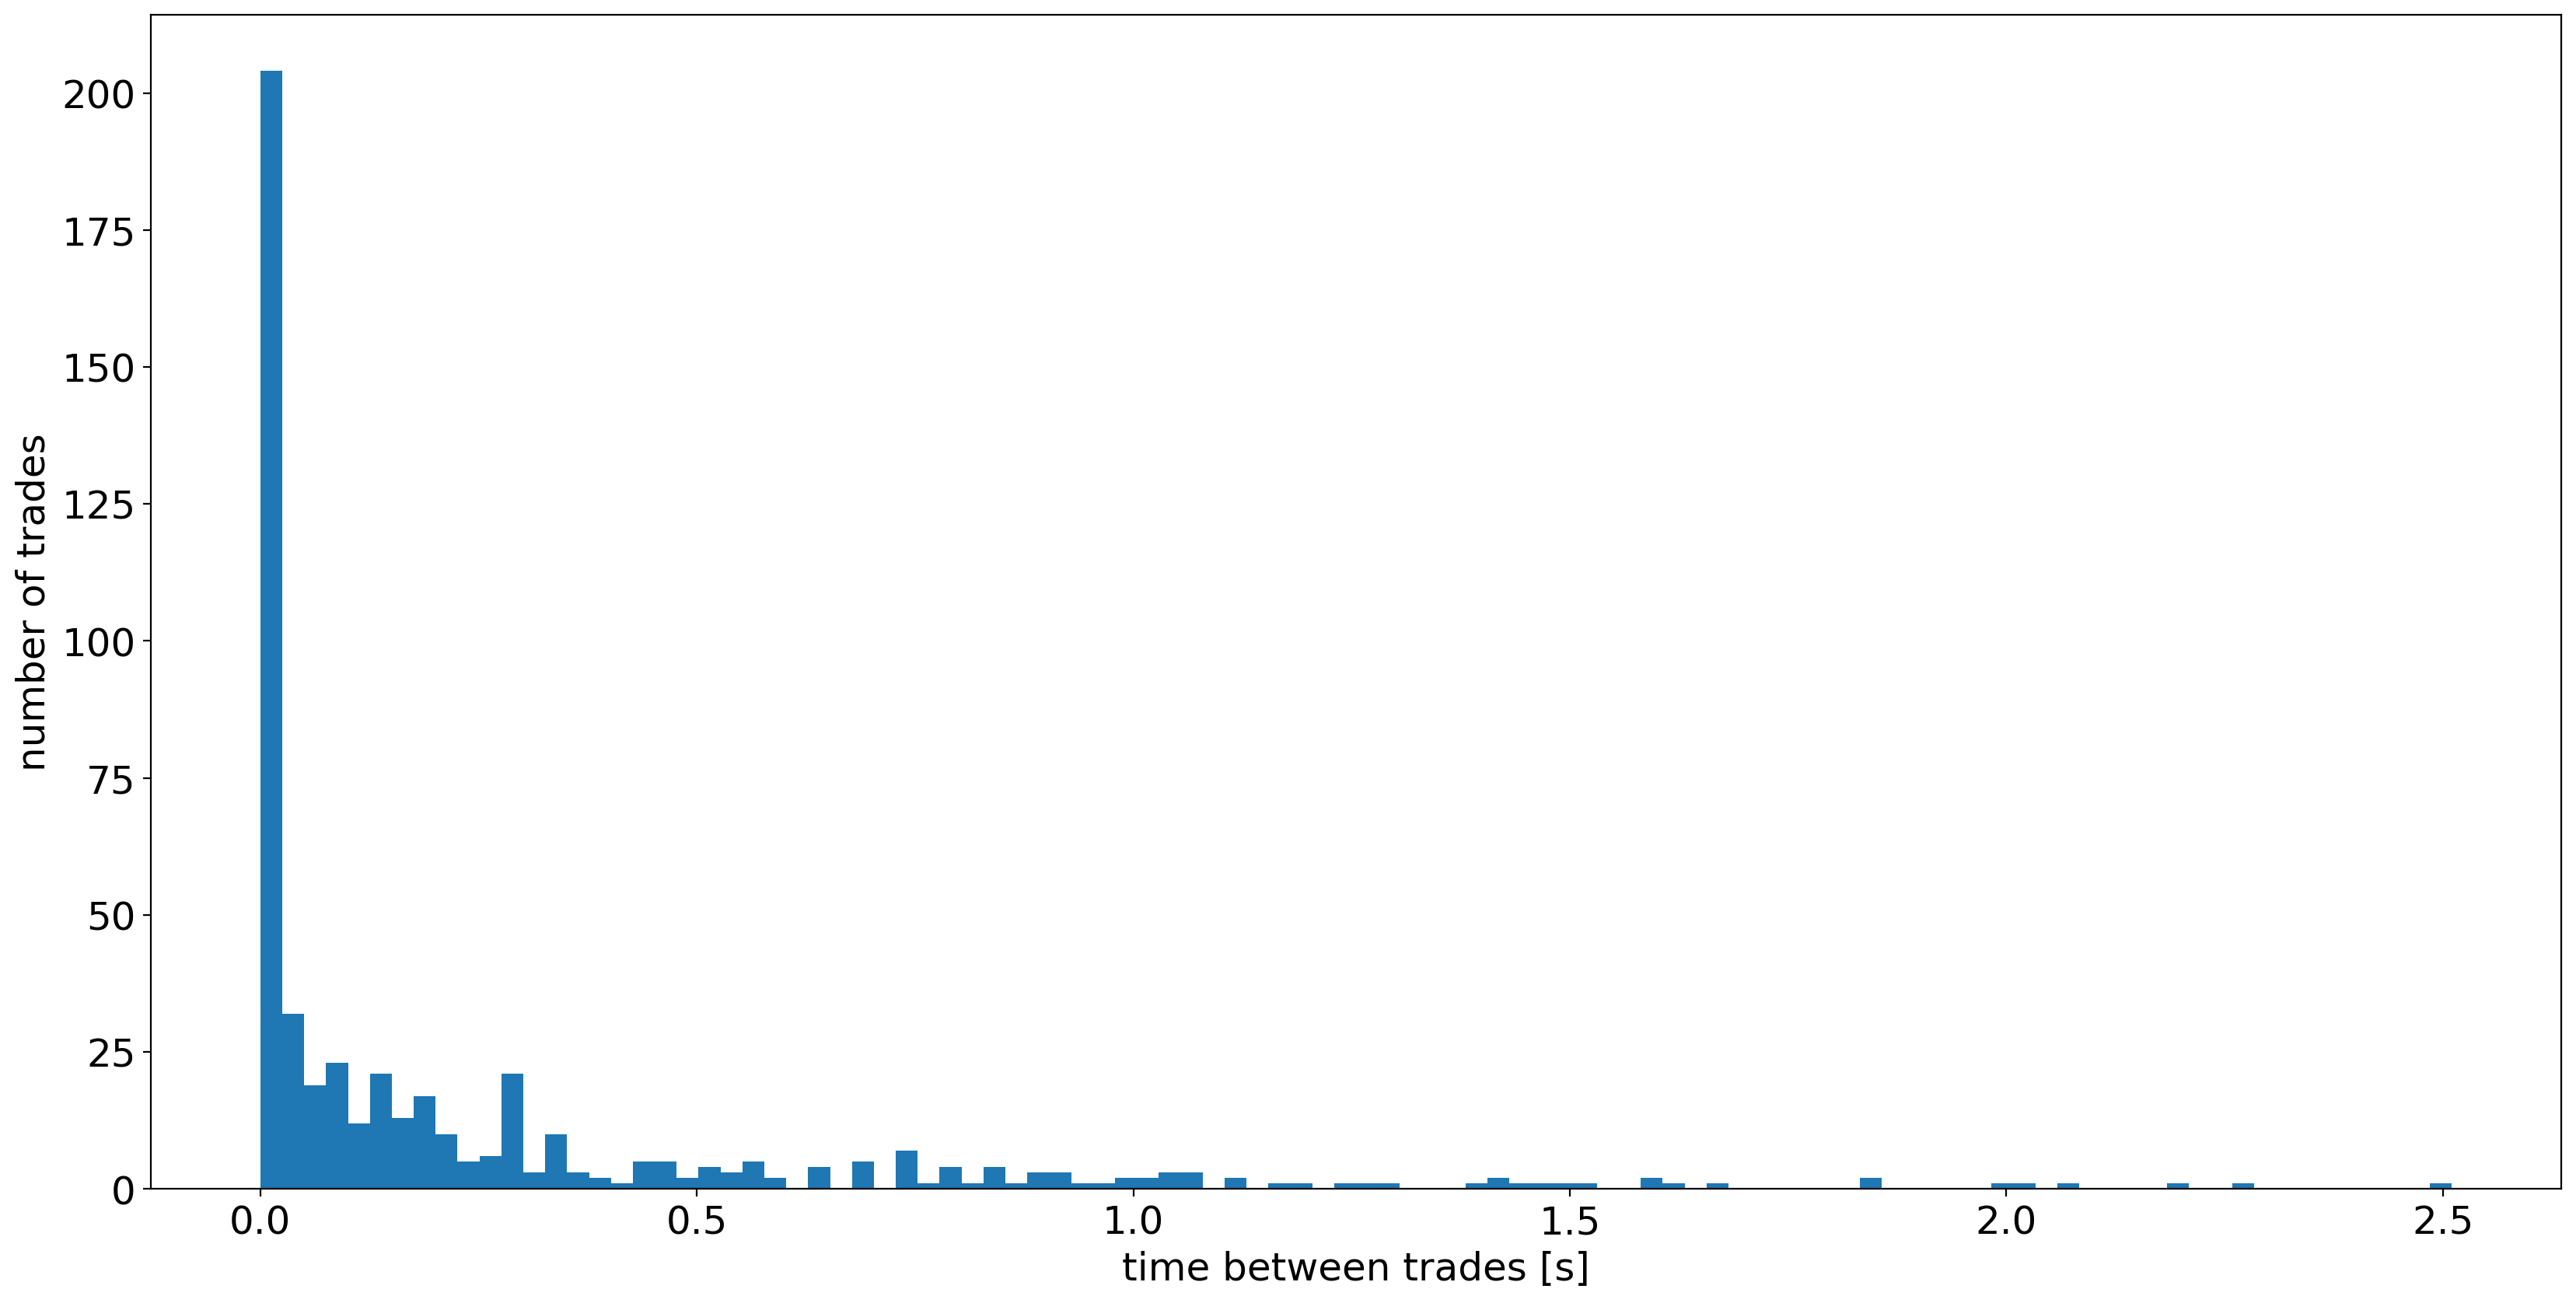

In [8]:
fs = [f.total_seconds() for f in np.diff(trade_dts)]
plt.hist(fs, bins=100)  # suppress unecessary output w/ the _ = ...
plt.xlabel(f"time between trades [s]")
plt.ylabel(f"number of trades")

## Determining Minimum `MIN_NOTIONAL` value across currencies

The `MIN_NOTIONAL` value is the minimum value of currency that can be traded for each trade (aka minimum order size). This was found to be ~\$5 when trading between DOGE and BTC. We want to find the minimum notional value between two currencies for testing.

The code block below builds the minimum notional values between every currency (stored in dictionary `min_notionals`). It is structured as a dict of dict. The keys of the outer dict is the _base_ currency for every currency exchange offered on Binance, and the keys of the inner dict is the _quote_ currency. This also gives us a map of every exchange.

The minimum notional value is given in the quote value - so if the minimum notional value for `ETH/BTC` is given in BTC. Therefore, we have to compare all of these minimum notional values in one currency.

In [3]:
import time
from collections import defaultdict

min_notionals = defaultdict(dict)
exchange_symbols = client.get_exchange_info()["symbols"]

t0 = time.perf_counter()
for symbol in exchange_symbols:
    for f in symbol["filters"]:
        if f["filterType"] == "MIN_NOTIONAL":
            mn = f["minNotional"]
            break
    min_notionals[symbol["baseAsset"]][symbol["quoteAsset"]] = float(mn)

min_notionals = dict(min_notionals)

In [4]:
client.get_exchange_info()

{'timezone': 'UTC',
 'serverTime': 1622605697897,
 'rateLimits': [{'rateLimitType': 'REQUEST_WEIGHT',
   'interval': 'MINUTE',
   'intervalNum': 1,
   'limit': 1200},
  {'rateLimitType': 'ORDERS',
   'interval': 'SECOND',
   'intervalNum': 10,
   'limit': 50},
  {'rateLimitType': 'ORDERS',
   'interval': 'DAY',
   'intervalNum': 1,
   'limit': 160000}],
 'exchangeFilters': [],
 'symbols': [{'symbol': 'ETHBTC',
   'status': 'TRADING',
   'baseAsset': 'ETH',
   'baseAssetPrecision': 8,
   'quoteAsset': 'BTC',
   'quotePrecision': 8,
   'quoteAssetPrecision': 8,
   'baseCommissionPrecision': 8,
   'quoteCommissionPrecision': 8,
   'orderTypes': ['LIMIT',
    'LIMIT_MAKER',
    'MARKET',
    'STOP_LOSS_LIMIT',
    'TAKE_PROFIT_LIMIT'],
   'icebergAllowed': True,
   'ocoAllowed': True,
   'quoteOrderQtyMarketAllowed': True,
   'isSpotTradingAllowed': True,
   'isMarginTradingAllowed': True,
   'filters': [{'filterType': 'PRICE_FILTER',
     'minPrice': '0.00000100',
     'maxPrice': '922327

In [2]:
min_notionals

defaultdict(dict, {})

To compare the minimum notional values for each of these, we need to get an exchange rate between every currency and USD. To get the exchange rate between two currencies, we execute `client.get_ticker(symbol="<currency_1><currency_2>")`.

Since we are rate limited, we want to make as few calls as possible. Therefore we
1. find the conversion from each coin to USD,
2. find the price of each coin compared to USD,
3. convert all min notionals to USD, and compare to find cheapest.

Below is the function to find the conversion to USD (often, it is simply just direct, but for some coins there is a middle coin to track).

In [ ]:
def exch_to_USD_map(cur):
    if cur in ("USDC", "USDT"):
        return ""
    elif "USDT" in min_notionals[cur]:
        return [cur + "USDT"]
    elif "USDC" in min_notionals[cur]:
        return [cur + "USDC"]

    paths = []
    for k in min_notionals[cur]:
        if k not in min_notionals.keys():
            continue
        # For each currency, exchange
        paths.append([cur + k] + exch_to_USD_map(k))
    return paths

In [ ]:
for k in min_notionals.keys():
    print(exch_to_USD_map(k))

In [12]:
def get_rates_to_usd(symbol) -> List[float]:
    if symbol in ("USDC", "USDT"):
        return [1]
    rates = []
    for p in exch_to_USD_map(symbol):
        if isinstance(p, str):
            rates.append(get_price_of_symbol(p))
        else:  # p is a list of symbols
            rates.append(
                prod([get_price_of_symbol(pp) for pp in p])
            )
    return rates

@cache
def get_price_of_symbol(symbol) -> float:
    "the cache allows us to hit the api as infrequently as possible"
    return float(client.get_ticker(symbol=symbol)['lastPrice'])

In [9]:
# min_notionals = {coin1: {coin2: min_notional, ...}, ...}

USD_min_notionals = {  # lol this is disgusting i am sorry, i had to do it
    k1: {k2: min([min_not_rate * v for v in get_rates_to_usd(k2)]) for k2, min_not_rate in k1_conversions.items() if k2 in min_notionals.keys()}
    for k1, k1_conversions in min_notionals.items()
}

In [10]:
USD_min_notionals["DOGE"]

KeyError: 'DOGE'